In [30]:
import sys
sys.path.append('../src/')

from datetime import datetime
import json

import ndjson
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
from wasabi import msg
from top2vec import Top2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from fastdtw import fastdtw
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt

from chronicles.representation import RepresentationHandler
from chronicles.misc import parse_dates
from chronicles.entropies import InfoDynamics
from chronicles.entropies.metrics import jsd, kld, cosine_distance
from chronicles.entropies.afa import adaptive_filter, normalize

In [2]:
# matplotlib settings
scale = 2
plt.rcParams.update({"text.usetex": False,
                    "font.family": "Times New Roman",
                    "font.serif": "serif",
                    "mathtext.fontset": "cm",
                    "axes.unicode_minus": False,
                    "axes.labelsize": 9*scale,
                    "xtick.labelsize": 9*scale,
                    "ytick.labelsize": 9*scale,
                    "legend.fontsize": 9*scale,
                    'axes.titlesize': 14,
                    "axes.linewidth": 1
                    })

In [3]:
signal_f = pd.read_csv('../models/220815_fulldocs_day/signal.csv').iloc[30:-30, :]
signal_p = pd.read_csv('../models/220815_prototypes_day/signal.csv').iloc[30:-30, :]

signal_week = pd.read_csv('../models/220815_prototypes_week/signal.csv').iloc[30:-30, :]
signal_year = pd.read_csv('../models/220815_prototypes_year/signal.csv').iloc[30:-30, :]

file_type = pd.read_csv('../data/file_type.csv', sep=';').dropna().rename(columns={'Batch': 'batch', 'Call Number': 'call_nr'})

## indicator variables

Text(0.5, 1.0, 'resonance at w=30')

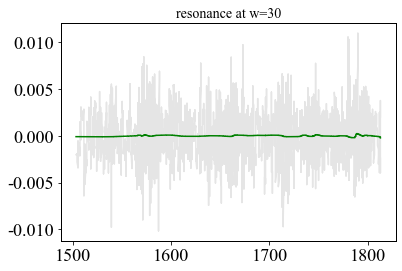

In [25]:
plt.plot(
    signal_p['year'],
    signal_p['resonance'],
    c='grey',
    alpha=0.2
)

plt.plot(
    signal_p['year'],
    signal_p['resonance_afa'],
    c='green'
)

plt.title('resonance at w=30')

Text(0.5, 1.0, 'transience at w=30')

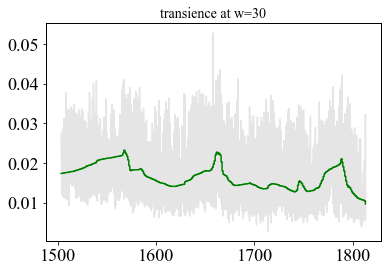

In [26]:
plt.plot(
    signal_p['year'],
    signal_p['transience'],
    c='grey',
    alpha=0.2
)

plt.plot(
    signal_p['year'],
    signal_p['transience_afa'],
    c='green'
)

plt.title('transience at w=30')

## prototype picking

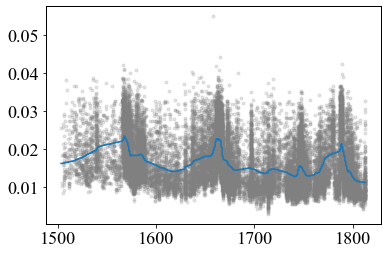

In [4]:
# novelty prototypes
plt.plot(
    signal_p['year'],
    signal_p['novelty'],
    '.',
    c='grey',
    alpha=0.2
)

plt.plot(
    signal_p['year'],
    signal_p['novelty_afa']
)

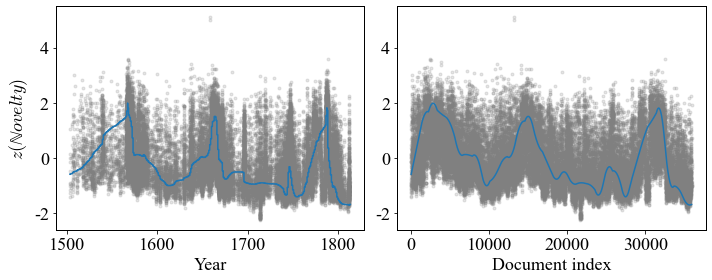

In [7]:
# novelty full
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(
    signal_f['year'],
    zscore(signal_f['novelty']),
    '.',
    c='grey',
    alpha=0.2
)

ax[0].plot(
    signal_f['year'],
    zscore(signal_f['novelty_afa'])
)

ax[0].set_xlabel('Year')
ax[0].set_ylabel('$z(\mathbb{N}ovelty)$')

ax[1].plot(
    signal_f.index,
    zscore(signal_f['novelty']),
    '.',
    c='grey',
    alpha=0.2
)

ax[1].plot(
    signal_f.index,
    zscore(signal_f['novelty_afa'])
)

ax[1].set_xlabel('Document index')
plt.tight_layout()

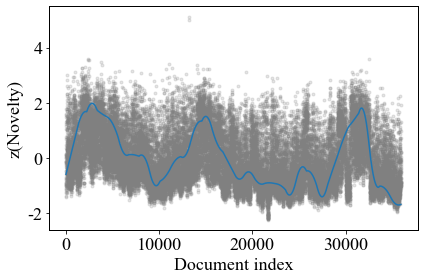

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(
    signal_f.index,
    zscore(signal_f['novelty']),
    '.',
    c='grey',
    alpha=0.2
)

plt.plot(
    signal_f.index,
    zscore(signal_f['novelty_afa'])
)

plt.xlabel('Document index')
plt.ylabel('z(Novelty)')
plt.tight_layout()

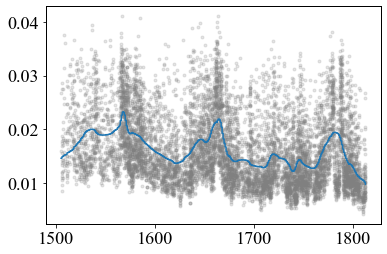

In [9]:
# novelty week
plt.plot(
    signal_week['year'],
    signal_week['novelty'],
    '.',
    c='grey',
    alpha=0.2
)

plt.plot(
    signal_week['year'],
    signal_week['novelty_afa']
)

Text(0.5, 0.05, 'novelty in grey, smoothed novelty in blue')

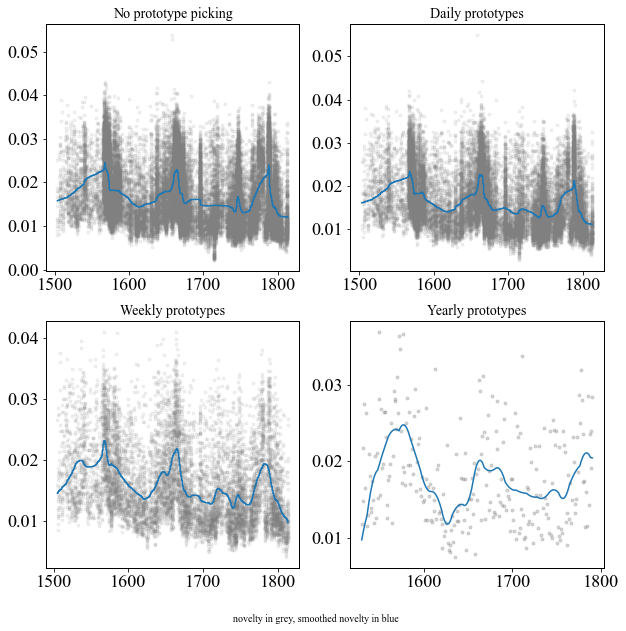

In [10]:
# in one plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(signal_f['year'], signal_f['novelty'], '.', c='grey', alpha=0.1)
axs[0, 0].plot(signal_f['year'], signal_f['novelty_afa'])
axs[0, 0].title.set_text('No prototype picking')

axs[0, 1].plot(signal_p['year'], signal_p['novelty'], '.', c='grey', alpha=0.1)
axs[0, 1].plot(signal_p['year'], signal_p['novelty_afa'])
axs[0, 1].title.set_text('Daily prototypes')

axs[1, 0].plot(signal_week['year'], signal_week['novelty'], '.', c='grey', alpha=0.1)
axs[1, 0].plot(signal_week['year'], signal_week['novelty_afa'])
axs[1, 0].title.set_text('Weekly prototypes')

axs[1, 1].plot(signal_year['year'], signal_year['novelty'], '.', c='grey', alpha=0.3)
axs[1, 1].plot(signal_year['year'], signal_year['novelty_afa'])
axs[1, 1].title.set_text('Yearly prototypes')

fig.text(.5, .05, 'novelty in grey, smoothed novelty in blue', ha='center')

## document length

Text(0.5, 0.05, 'z(novelty) in grey, z(document length) in orange')

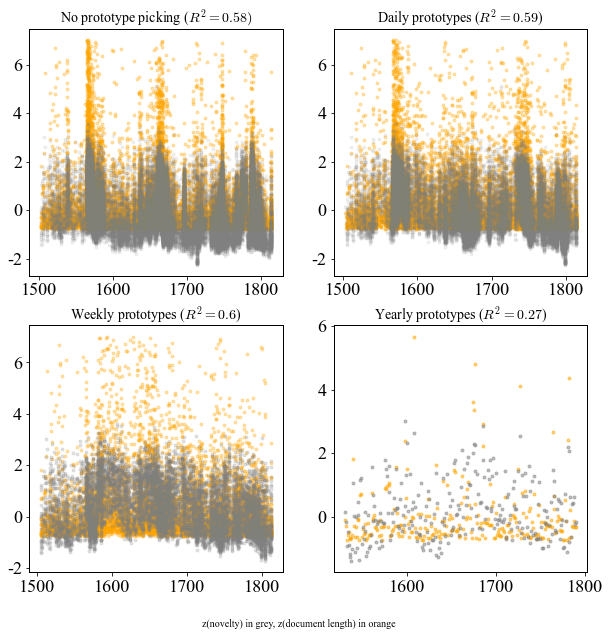

In [11]:
# with document length
colnames = ['novelty', 'novelty_afa', 'n_char']

for col in colnames:
    col_z = col + '_z'
    signal_f[col_z] = signal_f[col].transform(zscore)
    signal_p[col_z] = signal_f[col].transform(zscore)
    signal_week[col_z] = signal_f[col].transform(zscore)
    signal_year[col_z] = signal_f[col].transform(zscore)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(signal_f['year'], signal_f['n_char_z'], '.', c='orange', alpha=0.3)
axs[0, 0].plot(signal_f['year'], signal_f['novelty_z'], '.', c='grey', alpha=0.1)
# axs[0, 0].plot(signal_f['year'], signal_f['novelty_afa']*200-3)
axs[0, 0].title.set_text('No prototype picking ($R^2 = 0.58)$')

axs[0, 1].plot(signal_p['year'], signal_p['n_char_z'], '.', c='orange', alpha=0.3)
axs[0, 1].plot(signal_p['year'], signal_p['novelty_z'], '.', c='grey', alpha=0.1)
# axs[0, 1].plot(signal_p['year'], signal_p['novelty_afa']*200-3)
axs[0, 1].title.set_text('Daily prototypes ($R^2 = 0.59$)')

axs[1, 0].plot(signal_week['year'], signal_week['n_char_z'], '.', c='orange', alpha=0.3)
axs[1, 0].plot(signal_week['year'], signal_week['novelty_z'], '.', c='grey', alpha=0.2)
# axs[1, 0].plot(signal_week['year'], signal_week['novelty_afa']*200-3)
axs[1, 0].title.set_text('Weekly prototypes ($R^2 = 0.6$)')

axs[1, 1].plot(signal_year['year'], signal_year['n_char_z'], '.', c='orange', alpha=0.5)
axs[1, 1].plot(signal_year['year'], signal_year['novelty_z'], '.', c='grey', alpha=0.5)
# axs[1, 1].plot(signal_year['year'], signal_year['novelty_afa']*200-3)
axs[1, 1].title.set_text('Yearly prototypes ($R^2 = 0.27$)')

fig.text(.5, .05, 'z(novelty) in grey, z(document length) in orange', ha='center')

/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_89689/1308232499.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sf_ticks = sf_ticks.append(signal_f[signal_f.index == min(signal_f.index)]['year'])
/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_89689/1308232499.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sf_ticks = sf_ticks.append(signal_f[signal_f.index == max(signal_f.index)]['year'])
/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_89689/1308232499.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sp_ticks = sp_ticks.append(signal_p[signal_p.index == min(signal_p.index)]['year'])
/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_89689/1308232499.py:23: FutureWarn

Text(0.5, 0.05, 'novelty in grey, smoothed novelty in blue')

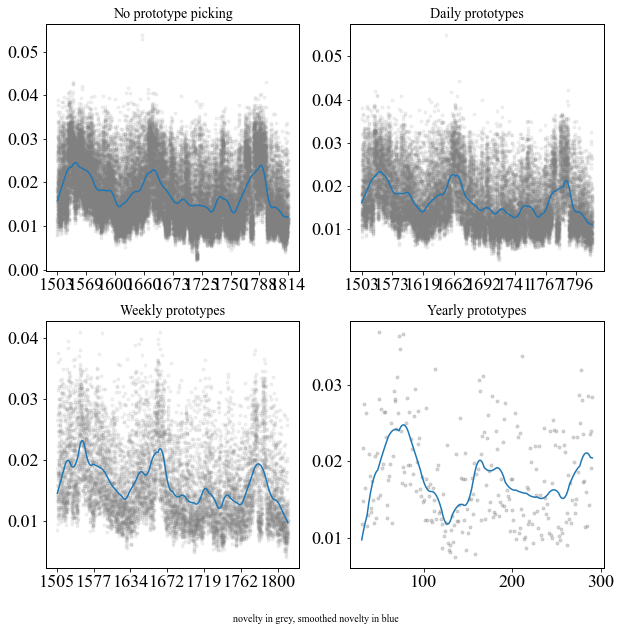

In [13]:
# straigt signal
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(signal_f.index, signal_f['novelty'], '.', c='grey', alpha=0.1)
axs[0, 0].plot(signal_f.index, signal_f['novelty_afa'])
axs[0, 0].title.set_text('No prototype picking')
sf_ticks = signal_f[signal_f.index % 4500 == 0]['year']
sf_ticks = sf_ticks.append(signal_f[signal_f.index == min(signal_f.index)]['year'])
sf_ticks = sf_ticks.append(signal_f[signal_f.index == max(signal_f.index)]['year'])
axs[0, 0].set_xticks(ticks=sf_ticks.index, labels=sf_ticks.tolist())

axs[0, 1].plot(signal_p.index, signal_p['novelty'], '.', c='grey', alpha=0.1)
axs[0, 1].plot(signal_p.index, signal_p['novelty_afa'])
axs[0, 1].title.set_text('Daily prototypes')
sp_ticks = signal_p[signal_p.index % 3000 == 0]['year']
sp_ticks = sp_ticks.append(signal_p[signal_p.index == min(signal_p.index)]['year'])
# sp_ticks = sp_ticks.append(signal_p[signal_p.index == max(signal_p.index)]['year'])
axs[0, 1].set_xticks(ticks=sp_ticks.index, labels=sp_ticks.tolist())

axs[1, 0].plot(signal_week.index, signal_week['novelty'], '.', c='grey', alpha=0.1)
axs[1, 0].plot(signal_week.index, signal_week['novelty_afa'])
axs[1, 0].title.set_text('Weekly prototypes')
sw_ticks = signal_week[signal_week.index % 1500 == 0]['year']
sw_ticks = sw_ticks.append(signal_week[signal_week.index == min(signal_week.index)]['year'])
# sw_ticks = sw_ticks.append(signal_week[signal_week.index == max(signal_week.index)]['year'])
axs[1, 0].set_xticks(ticks=sw_ticks.index, labels=sw_ticks.tolist())

axs[1, 1].plot(signal_year.index, signal_year['novelty'], '.', c='grey', alpha=0.3)
axs[1, 1].plot(signal_year.index, signal_year['novelty_afa'])
axs[1, 1].title.set_text('Yearly prototypes')

fig.text(.5, .05, 'novelty in grey, smoothed novelty in blue', ha='center')

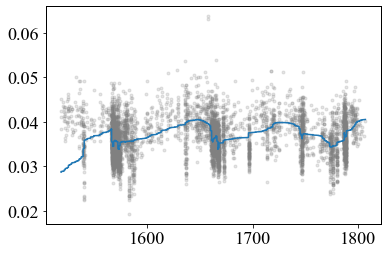

In [14]:
# novelty only long docs
plt.plot(
    signal_f_long_docs['year'],
    signal_f_long_docs['novelty'],
    '.',
    c='grey',
    alpha=0.2
)

plt.plot(
    signal_f_long_docs['year'],
    signal_f_long_docs['novelty_afa']
)

## individual chronicles, annotation scheme, date uncertainity

<AxesSubplot:xlabel='call_nr', ylabel='novelty'>

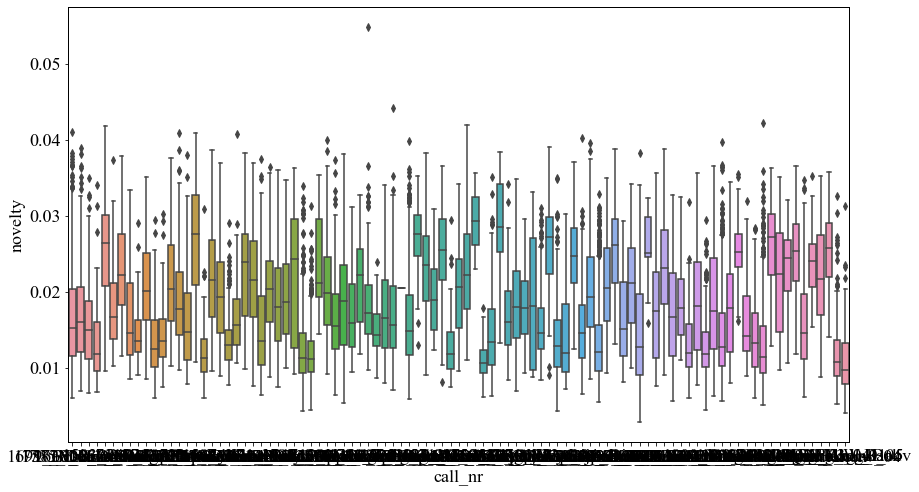

In [15]:
# per chronicle novelty
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=signal_p,
    x='call_nr',
    y='novelty'
)

In [16]:
signal_p.groupby('call_nr')['novelty'].describe()

,count,mean,std,min,25%,50%,75%,max
call_nr,,,,,,,,
1567_Amst_Bies,40.0,0.021377,0.005683,0.011748,0.015950,0.022144,0.025599,0.032685
1567_Amst_Reae,2.0,0.029321,0.008929,0.023007,0.026164,0.029321,0.032478,0.035634
1568_Gent_Vaer,152.0,0.026872,0.004372,0.012961,0.024684,0.027591,0.030097,0.035233
1570_Rott_Alle,1.0,0.020410,NaN,0.020410,0.020410,0.020410,0.020410,0.020410
1571_Gent_Camp,440.0,0.022690,0.005898,0.011052,0.017718,0.022213,0.027521,0.041913
...,...,...,...,...,...,...,...,...
1805_Haar_Vinn,478.0,0.014398,0.005126,0.006231,0.010373,0.013358,0.017698,0.035138
1808_Gent_Quic,678.0,0.012887,0.005137,0.005043,0.009339,0.011378,0.015464,0.042198
1813_Haag_Baak,190.0,0.011915,0.004827,0.005232,0.008835,0.010748,0.013564,0.032603


## date-tag uncertainity

<AxesSubplot:xlabel='merged_date_uncertainity', ylabel='novelty'>

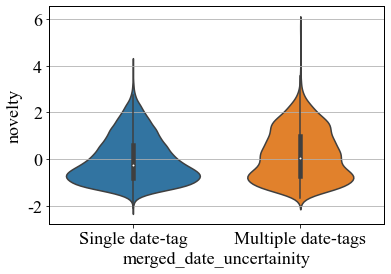

In [17]:
# date-tag uncertainity
signal_p['merged_date_uncertainity'] = ['Single date-tag' if val == 'unambiguous' else 'Multiple date-tags' for val in signal_p['date_uncertainity'].tolist()]

plt.figure(figsize=(6, 4))
plt.grid(axis='y')
sns.violinplot(
    data=signal_p.query('date_uncertainity != "varying resolutions"'),
    x='merged_date_uncertainity',
    y=signal_p['novelty'].transform(zscore)
)


<AxesSubplot:xlabel='date_uncertainity', ylabel='count'>

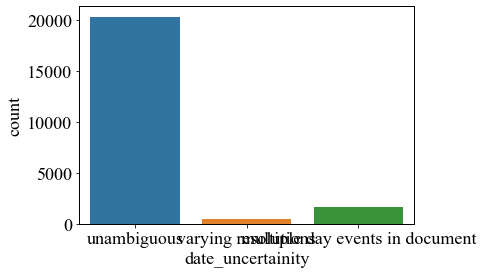

In [27]:
sns.countplot(
    x=signal_p_batches['date_uncertainity']
)

<AxesSubplot:xlabel='batch', ylabel='novelty'>

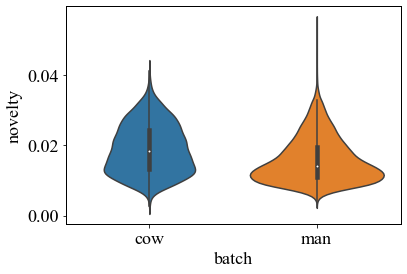

In [18]:
# cow file check
signal_p_batches = signal_p.merge(file_type, how='left', on='call_nr')
signal_p_batches.to_csv('../models/220815_prototypes_day/signal_p_batches.csv', index=False)

# %%
# difference in novelty
sns.violinplot(
    data=signal_p_batches,
    x='batch',
    y='novelty'
)

<AxesSubplot:xlabel='year', ylabel='novelty'>

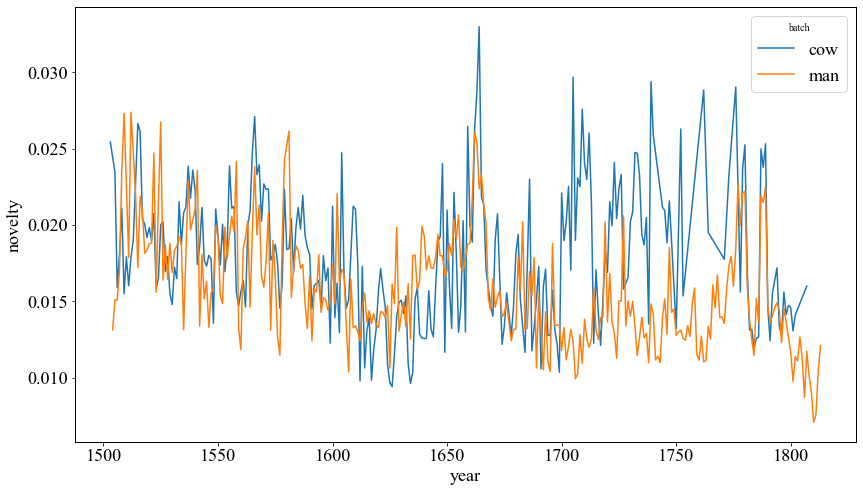

In [20]:
# share of docs from either
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=signal_p_batches,
    x='year',
    y='novelty',
    hue='batch',
    ci=None
)

<AxesSubplot:xlabel='vec_x', ylabel='vec_y'>

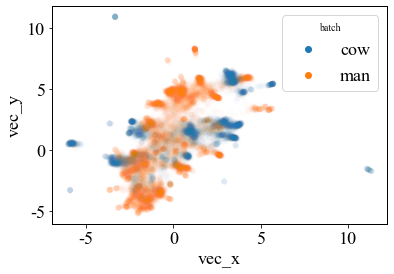

In [22]:
# difference in vector position
sns.scatterplot(
    data=signal_p_batches,
    x='vec_x',
    y='vec_y',
    hue='batch',
    alpha=0.01
)

<AxesSubplot:xlabel='call_nr', ylabel='n_char'>

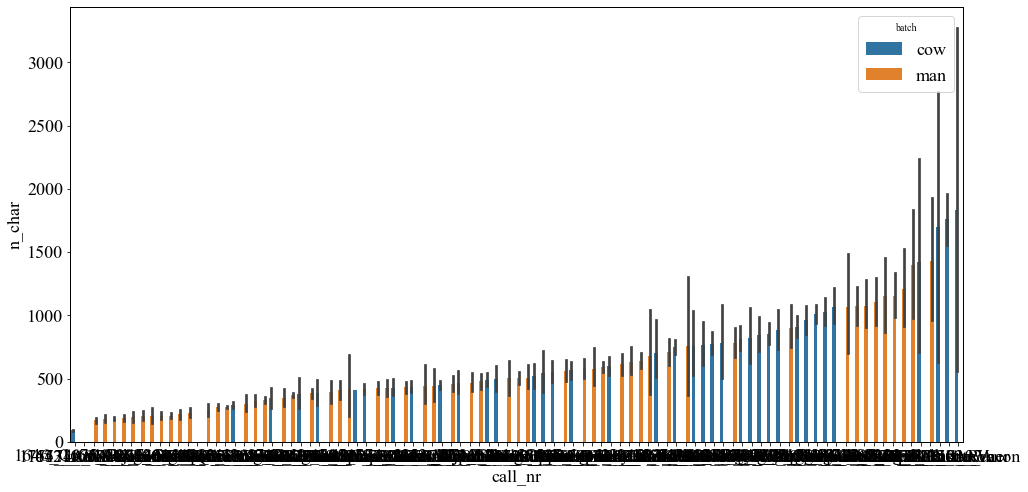

In [23]:
bar_order = signal_p_batches.groupby(["call_nr"])['n_char'].aggregate(np.mean).reset_index().sort_values('n_char')
plt.figure(figsize=(16, 8))
sns.barplot(
    data=signal_p_batches,
    x='call_nr',
    y='n_char',
    hue='batch',
    order=bar_order['call_nr']
)

<AxesSubplot:xlabel='batch', ylabel='n_char'>

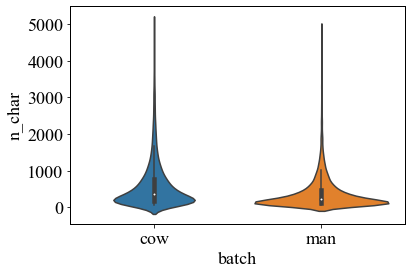

In [28]:
# difference in n_char
sns.violinplot(
    data=signal_p_batches,
    x='batch',
    y='n_char'
)

## typical words for high/low novelty docs

count    22516.000000
mean         0.016858
std          0.006748
min          0.002825
25%          0.011508
50%          0.015411
75%          0.021401
max          0.054867
Name: novelty, dtype: float64

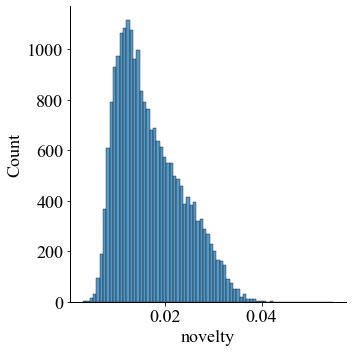

In [29]:
sns.displot(signal_p['novelty'])
signal_p['novelty'].describe()

In [32]:
high_novelty = signal_p.query('novelty >= 0.021')
low_novelty = signal_p.query('novelty <= 0.011')

hn_tfidf = TfidfVectorizer()
hn_vects = hn_tfidf.fit_transform(high_novelty['text'].tolist())

ln_tfidf = TfidfVectorizer()
ln_vects = ln_tfidf.fit_transform(low_novelty['text'].tolist())

# sort
hn_features = np.array(hn_tfidf.get_feature_names_out())
hn_sorting = np.argsort(hn_vects.toarray()).flatten()[::-1]


ln_features = np.array(ln_tfidf.get_feature_names_out())
ln_sorting = np.argsort(ln_vects.toarray()).flatten()[::-1]

In [33]:
n=20
hn_top_words = hn_features[hn_sorting][:n]
ln_top_words = ln_features[ln_sorting][:n]

In [34]:
hn_top_words

array(['zich', 'onttrekken', 'bepalen', 'van', 'zullen', 'maal', 'oud',
       'de', 'en', 'wacht', 'uitgezonderd', 'loonwagten', 'vanwege',
       'uittrekken', 'vaderlandschen', 'goedge', 'secretatis',
       'onderscheidene', 'gezindheden', 'voowendsels'], dtype=object)

In [35]:
ln_top_words

array(['buitenhof', 'brandwacht', 'inge', 'gedane', 'betrokken', 'nenhof',
       'volge', 'passage', 'bekendmaking', 'het', 'naast', 'stadhuis',
       'vrij', 'bin', 'wacht', 'sedert', 'de', 'burgers', 'dagen',
       'eenige'], dtype=object)